In [1]:
import os
os.chdir(os.getcwd())

In [2]:
#limit VRAM usage
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2023-03-20 15:18:56.301968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 15:18:56.853877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/rishabh/miniconda3/envs/tf/lib/
2023-03-20 15:18:56.854468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/rishabh/miniconda3/envs/tf/lib/
2023-03-20 15:18:56.854475: W tensorflow/compiler/tf2tens

In [3]:
#check and remove dodgy images from dataset
import cv2
import imghdr

data_dir = 'data'
image_exts = ['jpg', 'jpeg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image extension not supported: ', format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image: ', format(image_path))

In [4]:
#creating a dataset using keras and all the images in the data folder
import numpy as np
from matplotlib import pyplot as plt
#building a data pipeline
data = tf.keras.utils.image_dataset_from_directory('data')

#scaling the data to be between 0 and 1 from 0 to 255
# logic - scaled = batch[0] / 255 but we apply this directly to the pipeline
data = data.map(lambda x, y: (x / 255, y))

Found 47009 files belonging to 2 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-20 15:19:21.839710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 15:19:21.840166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 15:19:21.840342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 15:19:21.840470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [5]:
#making it an interator to allow us to loop through the data
data_iterator = data.as_numpy_iterator() # type: ignore
#grab a batch of data
batch = data_iterator.next()
#batch[0].shape #shape of the images
batch[1] 
# Classification labels: 0 - Female, 1 - Male.

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1], dtype=int32)

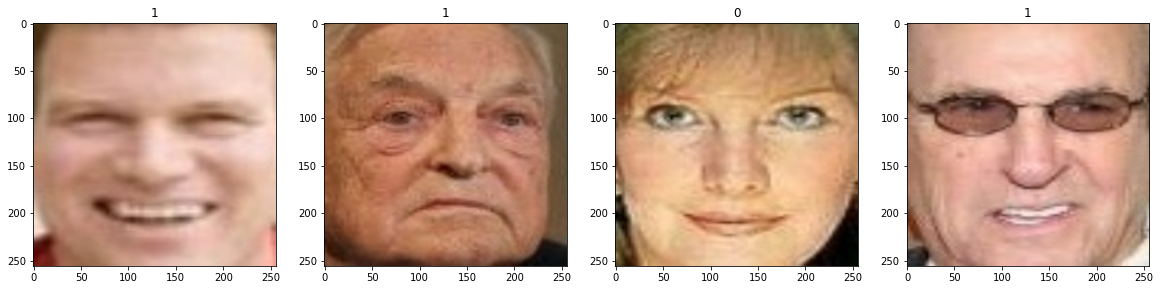

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    #ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])
    #ax[idx].title.set_text(batch[1][idx])

In [7]:
len(data)

1470

In [8]:
#making training, validation and test sets, they all add up to len(data) = 1470 in this case
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

In [9]:
train = data.take(train_size) # type: ignore
val = data.skip(train_size).take(val_size) # type: ignore
test = data.skip(train_size+val_size).take(test_size) # type: ignore

In [11]:
#building the model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [14]:
#training the model
logdir = 'logs'

In [15]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [16]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-03-20 15:20:40.649382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-20 15:20:41.102854: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 15:20:41.614906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-20 15:20:42.066672: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3024984920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-20 15:20:42.066689: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-20 15:20:42.069827: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-20 15:20:42.12295

1029/1029 [==============================] - 27s 22ms/step - loss: 0.3049 - accuracy: 0.8719 - val_loss: 0.2068 - val_accuracy: 0.9208
Epoch 2/20
1029/1029 [==============================] - 23s 23ms/step - loss: 0.1877 - accuracy: 0.9287 - val_loss: 0.1691 - val_accuracy: 0.9355
Epoch 3/20
1029/1029 [==============================] - 23s 23ms/step - loss: 0.1538 - accuracy: 0.9432 - val_loss: 0.1702 - val_accuracy: 0.9352
Epoch 4/20
1029/1029 [==============================] - 23s 22ms/step - loss: 0.1244 - accuracy: 0.9534 - val_loss: 0.1666 - val_accuracy: 0.9395
Epoch 5/20
1029/1029 [==============================] - 23s 22ms/step - loss: 0.0946 - accuracy: 0.9656 - val_loss: 0.1756 - val_accuracy: 0.9424
Epoch 6/20
1029/1029 [==============================] - 23s 22ms/step - loss: 0.0742 - accuracy: 0.9727 - val_loss: 0.2489 - val_accuracy: 0.9272
Epoch 7/20
1029/1029 [==============================] - 23s 22ms/step - loss: 0.0515 - accuracy: 0.9817 - val_loss: 0.2257 - val_accura